# Configuration models and synthetic networks
In order to understand the significance of our network's topology we built two synthetic models which have the same properties as our network. We kept the degree distribution, number of zealots and their ratios (number of blacklisted / whitelisted nodes). The model has the following configurations: 

<b>Randomly shuffled zealots:</b>  We kept the network structure and topology as it is. Nodes and links were in the original configuration. We also kept the susceptibility of nodes, but we shuffled the zealot's labels at random.

Then we run our configuration of the voter model on a projected network. We ran $m=50$ realizations of the voter model and plot the relative number of changes. Then we choosed 3/10ths as a testing set, compute the confusion matrix, ROC curve and total accuracy.

In [1]:
import voter_model as vm
from kassiopea import Kassiopea
from tools import plot_roc, plot_pdf, round_acc, round_acc2

from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import random as r
import time
import csv

In [2]:
start = time.time()
K = Kassiopea()

# Statistics of initial states counts
blacklisted = 0
whitelisted = 0
uknown = 0

black_ip = 0
white_ip = 0

black_dns = 0
white_dns = 0

ip = []
dns = []

# Add network's nodes and edges from file
with open("data/data.csv") as csvfile: 
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Create domain's nodes
        if row["domain"] not in K.get_nodes():
            label = int(row["domain_state"])
            zea = 1
            if label == 0:
                label = 0
                uknown += 1
            else:
                if label == 1:
                    whitelisted += 1
                    white_dns += 1
                else:
                    blacklisted += 1
                    black_dns += 1
                    
            K.add_node(row['domain'], zea=zea, label=0)
            dns.append(row['domain'])
        
        # Create ip's nodes 
        if row["ip"] not in K.get_nodes():
            label = int(row["ip_state"])
            if label == 0:
                zea = 1
                uknown += 1
            else:
                if label == 1:
                    whitelisted += 1
                    white_ip += 1
                else:
                    blacklisted += 1
                    black_ip += 1
    
            K.add_node(row["ip"], zea=zea, label=0)
            ip.append(row["ip"])
        
        # Create an edge between IP <-> Domain
        K.add_edge(row['domain'], row['ip'])
        
print(f"Network is created in: {round(time.time() - start, 3)}s")

Network is created in: 552.404s


In [3]:
# Assign "zeas" at random
random_ip = r.sample(ip, black_ip + white_ip)
random_dns = r.sample(dns, black_dns + white_dns)

num_nodes = len(K.get_nodes())
K.update_label([0] * num_nodes)
K.update_zea([1] * num_nodes)

for n in random_ip:
    i = K.list_nodes.index(n)
    K.update_zea_node(i, 0)
    K.update_label_node(i, int(round((r.uniform(0, 1) < black_ip / white_ip) * (-2) + 1 , 0)))

for n in random_dns:
    i = K.list_nodes.index(n)
    K.update_zea_node(i, 0)
    K.update_label_node(i, int(round((r.uniform(0, 1) < white_dns / black_dns) * 2 -1 , 0)))

In [4]:
original_labels = deepcopy(K.label)
original_zeas = deepcopy(K.zea)

# Selecting the "zeas" from the dataset
zeas = [i for i, v in enumerate(original_zeas) if v == 0]
num_zeas = len(zeas)

In [5]:
# Statistics of final states counts
blacklisted_f = 0
whitelisted_f = 0
uknown_f = 0
    
rate = {}
stopping_time = []

# Num of realisation of Voter Model
m = 50

# Fraction of the trainning data set
accs = 3 / 10
num_ch = int(num_zeas * accs)
random_z = r.sample(zeas, num_ch)

# Set the lables to original labels
K.update_label(original_labels)
K.update_zea(original_zeas)

# Trainning zeas are labeled as unknown
for n in random_z:
    K.update_zea_node(n, 1)
    K.update_label_node(n, 0)

# Deepcopy current labels with trainning zeas
labels = deepcopy(K.label)
rate = [0] * num_nodes    

# Running m independent realisation of Voter Model
for i in range(m):
    # Set the labels to original ones
    K.update_label(labels)
    stop = time.time()
    hist, x, st, u = vm.voter_model_realisation(K)
    print(f"Time used for this realization: {round(time.time() - stop, 3)}s realization: {i + 1}/{m}.")
    
    # Assign rate for later computing of longterm average
    for n in range(num_nodes):
        rate[n] += int(K.label[n])

Time used for this realization: 6.537s realization: 1/50.
Time used for this realization: 9.94s realization: 2/50.
Time used for this realization: 7.67s realization: 3/50.
Time used for this realization: 6.471s realization: 4/50.
Time used for this realization: 6.221s realization: 5/50.
Time used for this realization: 6.111s realization: 6/50.
Time used for this realization: 6.281s realization: 7/50.
Time used for this realization: 6.148s realization: 8/50.
Time used for this realization: 5.857s realization: 9/50.
Time used for this realization: 6.336s realization: 10/50.
Time used for this realization: 6.342s realization: 11/50.
Time used for this realization: 6.509s realization: 12/50.
Time used for this realization: 5.722s realization: 13/50.
Time used for this realization: 5.946s realization: 14/50.
Time used for this realization: 5.801s realization: 15/50.
Time used for this realization: 5.899s realization: 16/50.
Time used for this realization: 6.034s realization: 17/50.
Time use

After m realisations are run we can make some statistics and take a look on accuracy. Under confustion matrix we understand: 
$$\begin{bmatrix}
    TrueWhitelisted & FlaseWhitelisted \\
    FalseBlacklisted & TrueBlacklisted \\
\end{bmatrix}$$

In [6]:
# Confusion matrix
confusion_matrix = np.zeros((2,2))

def round_1(x):
    if x < 0:
        return -1
    elif x > 0:
        return +1
    else:
        return 0
    
for n in random_z: 
    if original_labels[n] == round_1(rate[n]):
        if original_labels[n] == 1:
            confusion_matrix[0][0] +=1
        else:
            confusion_matrix[1][1] +=1
    else:
        if original_labels[n] == 1:
            confusion_matrix[0][1] +=1
        else:
            confusion_matrix[1][0] +=1
            
print("Confusion matrix, relative numbers")  
print(confusion_matrix[0] / (confusion_matrix[0][1] + confusion_matrix[0][0]))
print(confusion_matrix[1] / (confusion_matrix[1][1] + confusion_matrix[1][0]), "\n")
print("Confusion matrix, absolute numbers")
print(confusion_matrix)

print(f"Accuracy: {round((confusion_matrix[0][0] + confusion_matrix[1][1]) / len(random_z), 3)}\n")

blacklisted_f = 0
whitelisted_f = 0
uknown_f = 0

for n in range(num_nodes):
    if (rate[n] / m) < 0:
        blacklisted_f += 1
    elif (rate[n] / m) > 0:
        whitelisted_f += 1
    else:
        uknown_f += 1

# Statistics about states
print(f'#Uknown: (before, after) {(uknown_f, uknown)}')
print(f'#Whitelisted: (before, after) {(whitelisted_f, whitelisted)}')
print(f'#Blacklisted: (before, after) {(blacklisted_f, blacklisted)}')
print(f'Ratio whitelisted/blacklisted in the end: {round(whitelisted_f / blacklisted_f, 3)}')
print(f'Ratio whitelisted/blacklisted in the beginning: {round(whitelisted / blacklisted, 3)}')
print(f'#nodes: {len(K.get_nodes())}')
print(f'#edges: {len(K.get_edges())}')

Confusion matrix, relative numbers
[0.04977376 0.95022624]
[0.11748634 0.88251366] 

Confusion matrix, absolute numbers
[[ 11. 210.]
 [ 86. 646.]]
Accuracy: 0.689

#Uknown: (before, after) (4930, 93674)
#Whitelisted: (before, after) (8720, 643)
#Blacklisted: (before, after) (83203, 2536)
Ratio whitelisted/blacklisted in the end: 0.105
Ratio whitelisted/blacklisted in the beginning: 0.254
#nodes: 96853
#edges: 137289


In this section, we would like to present ROC curve and comparison between rate, eigenvalue centrality, degree distibution

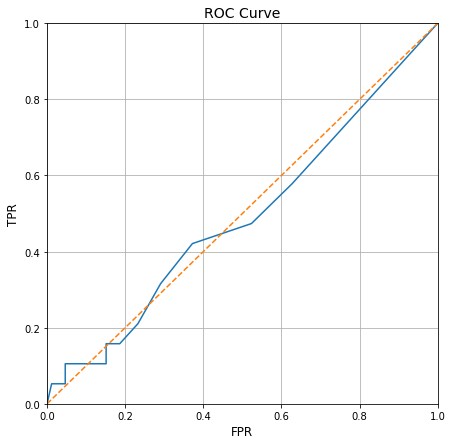

In [7]:
l = 50 
wl = [(rate[n] / m) for n in random_z if original_labels[n] == 1]
bl = [(rate[n] / m) for n in random_z if original_labels[n] == -1]

hist_wl, bins = np.histogram(wl, bins=np.linspace(0, 1, l + 1), density=True)
hist_bl, bins = np.histogram(bl, bins=np.linspace(0, 1, l + 1), density=True)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
plot_roc(hist_bl,hist_wl, ax, np.arange(0, l))
plt.show()

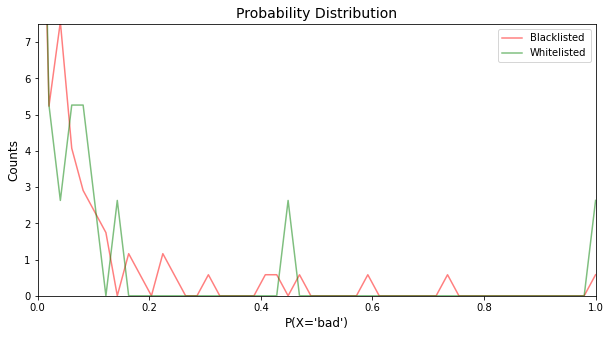

In [8]:
x = np.linspace(0, 1, num=l)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_pdf(hist_bl, hist_wl, ax, x)
plt.show()

### Sources:
[1] Receiver Operating Characteristic Curves Demystified (in Python), https://towardsdatascience.com/receiver-operating-characteristic-curves-demystified-in-python-bd531a4364d0